# Funções Base

In [1]:
from matplotlib.pyplot import *
import numpy as np
import h5py
from Data_Core.experiment import *
from Data_Core.digital_twin import *
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
import sklearn
%load_ext autoreload
from skimage import feature
import scipy
from skimage.filters import gabor
from skimage.filters import threshold_otsu

from skimage.filters import threshold_isodata
from skimage.morphology import erosion, disk,square, closing

from scipy import signal

from skimage.filters import threshold_otsu
from collections import Counter



In [2]:
%autoreload 2

In [3]:
#find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts - w))

def find_index(wavelenghts,w):
    return np.argmin(np.abs(wavelenghts - w))

In [4]:
def read_data_map(file):
    hf = h5py.File(file, 'r')
    spectrums = np.array(hf.get('intensities'))
    positions = np.array(hf.get('position'))
    wavelengths = np.array(hf.get('wavelengths'))
    positions = np.delete(positions, 0, 0)
    spectrums = np.delete(spectrums, 0, 0)
    x = positions[:, 0]
    y = positions[:, 1]
    xy = np.lexsort((y, x))

    hf.close()
    return spectrums[xy], wavelengths, positions

# Amostra 2

In [5]:

filename = '2.Lepidolite_Zinnwaldite_Albite'
def read_data_map(file):
 
    hf = h5py.File(file + '.h5', 'r')
    sample = file.split("\\")[-1]
    keys = [key for key in hf.keys()]
    sample = keys[0].split(' ')[-1]
 
    spectrums = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['Shot_0']['Pro']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    positions = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['position']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    wavelengths = np.array(hf['System properties']['wavelengths'])
 
   
    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
   
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:, 0],positions[:, 1]))
    spectrums = spectrums[indexes, :]
    spectrums = np.array(spectrums.reshape((ny, nx, -1)))
    # print(spectrums.shape)
    positions = np.array(positions[indexes])
   
    hf.close()
    return  spectrums,positions,wavelengths


spectrum, positions,wavelengths = read_data_map(filename)

pro_data = 1*spectrum

pro_data_norm=pro_data.copy()
for i in range(0,pro_data.shape[0]):
    for j in range(0,pro_data.shape[1]):
        spec = 1 * pro_data[i,j, :]
        sum_spec=np.sum(spec)
        pro_data_norm[i,j,:]=spec/sum_spec
pro_data_norm=np.array(pro_data_norm)


## 1.1 Deteção de Elementos

In [6]:
maps=spectrum.copy()
wavelengths=wavelengths.flatten()

In [7]:
maps=np.transpose(maps,axes=(2,0,1))

In [8]:
el=[610.22,309.27,288.13,777.194,656.285,478.94,588.99,769.81,373.48,780.03]
el_n=['Li','Al','Si','O','H','F','Na','K','Fe','Rb']

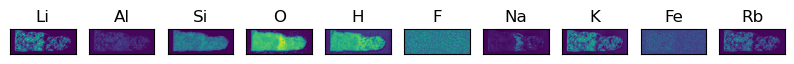

In [9]:

fig,ax=subplots(1,len(el),figsize=(10,3))
for i in range(len(el)):
    ax[i].imshow(maps[find_index(wavelengths,el[i])])
    ax[i].set_title(el_n[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [10]:
el=[610.22,309.27,288.13,777.194,656.285,588.99,769.81,780.03]
el_n=['Li','Al','Si','O','H','Na','K','Rb']
# F e Fe nao conseguimos detetar

In [11]:
normalized_spec1=np.transpose(maps.reshape(-1,maps.shape[1],maps.shape[2]),axes=(1,2,0))

nx, ny = normalized_spec1.shape[1], normalized_spec1.shape[0]
dx = 0.5
dy = 0.5
 
freqs_x = 2*np.pi*np.fft.fftfreq(nx, dx)
freqs_y = 2*np.pi*np.fft.fftfreq(ny, dy)
 
def fft_feature(mmap, pixel_size_small):
    fft_map = np.array([np.fft.fftshift(np.fft.fft2(mmap[:, :, i])) for i in tqdm(range(0, (mmap.shape[-1])))])
    fft_map[:, fft_map.shape[1]//2, fft_map.shape[2]//2] = 0
 
    kxx, kyy = np.meshgrid(np.fft.fftshift(freqs_x), np.fft.fftshift(freqs_y))
 
    object_size_small = pixel_size_small*dx
    size_kspace_small = 2*np.pi/object_size_small/2*1.5
 
    R = abs(np.sqrt(kxx**2 + kyy**2))
 
    sum1 = np.sum(np.abs(fft_map[:,(R < size_kspace_small)]), axis = (1))
    max1 = np.sum(np.abs(fft_map), axis = (1, 2))
 
    sums = np.array(sum1)/np.array(max1)
 
    return sums, fft_map
 
sums, fft_m = fft_feature(normalized_spec1, 10)

100%|██████████| 16384/16384 [00:16<00:00, 1002.55it/s]


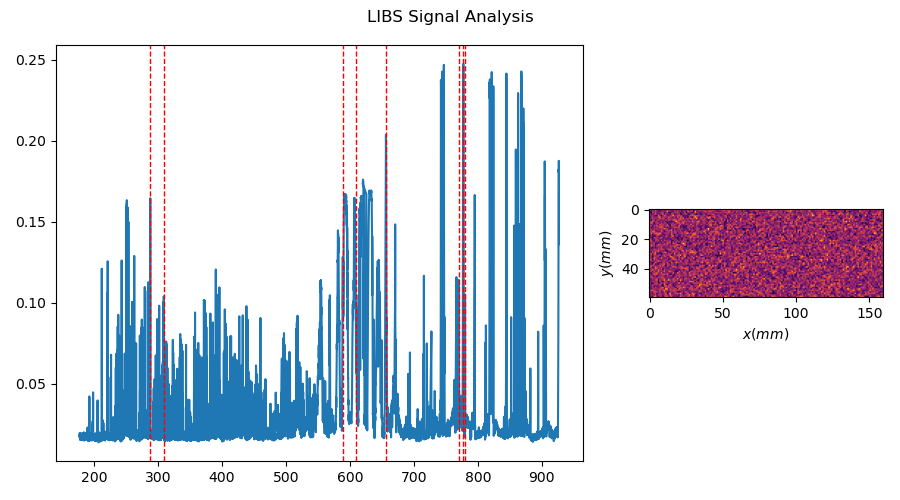

In [12]:

find_index = lambda wavelenghts,w : np.argmin(np.abs(wavelengths-w))
    
%matplotlib widget
fig, ax = subplots(1,2, figsize = (9, 5), gridspec_kw = {'width_ratios': [0.9, 0.4]})
fig.suptitle('LIBS Signal Analysis')

axs = ax[0]
axs.plot(wavelengths,sums)
for i in range(len(el)):
    axs.axvline(el[i],linestyle='--',color='red',lw=1)
axs = ax[1]
axs.imshow(maps[100,:, :], cmap = cm.inferno)
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')



def update_map(wn):
    im = ax[1].imshow(maps[wn,:, :],
                     interpolation = 'none')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths, ix)
    if event.inaxes == ax[0] or ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()

In [13]:
peaks=scipy.signal.find_peaks(sums)[0]
sel_maps=[]
sel_wavs=[]
heights=sums[peaks]
for i in range(len(peaks)):
    if heights[i]>0.09:
        sel_maps.append(maps[peaks[i]])
        sel_wavs.append([wavelengths[peaks[i]]])

sel_maps=np.array(sel_maps)
sel_maps=sel_maps.reshape(-1,maps.shape[1],maps.shape[2])

In [14]:
sel_wavs=np.array(sel_wavs)

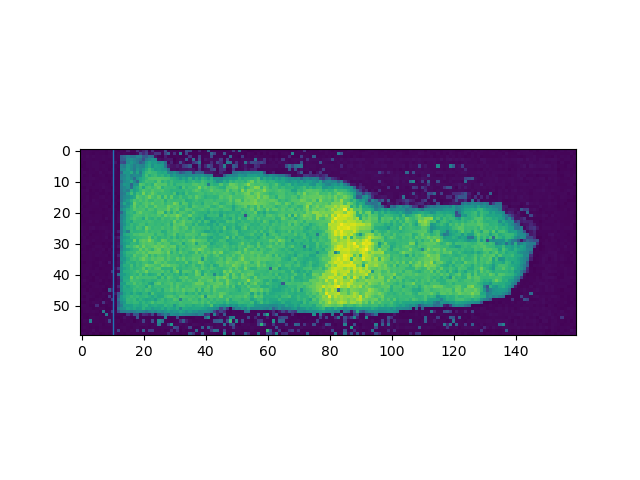

In [15]:
plt.figure()
plt.imshow(maps[find_index(wavelengths,el[3])])
plt.axvline(10,lw=1)

In [16]:
# para os mapas que estão dentro dos parametros da fft retirar os que tem sinal fora da rocha
sel_maps_f=sel_maps.reshape(-1,sel_maps.shape[1]*sel_maps.shape[2])
thresholds=np.array([threshold_otsu(sel_maps_f[i]) for i in range(sel_maps.shape[0])])
final_masks=[]
for map in range(len(thresholds)):
    c_mask=np.zeros(sel_maps_f.shape[1])
    for i in range(sel_maps_f.shape[1]):
        if sel_maps_f[map,i]>thresholds[map]:
            c_mask[i]=1
    final_masks.append(c_mask)

final_masks=np.array(final_masks).reshape(-1,sel_maps.shape[1],sel_maps.shape[2])


new_maps=[]
edge=[]
new_wavs=[]
#ajustar regiao fora do mapa
for w in tqdm(range(final_masks.shape[0])):
    current_map=final_masks[w,:,:]
    pixel_sum=np.sum(current_map[:,:10])
    if pixel_sum <1:
        new_maps.append(sel_maps[w,:,:])
        new_wavs.append(sel_wavs[w])
new_maps=np.array(new_maps)
print(sel_maps.shape)
print(new_maps.shape)

100%|██████████| 232/232 [00:00<00:00, 28843.92it/s]

(232, 60, 160)
(55, 60, 160)


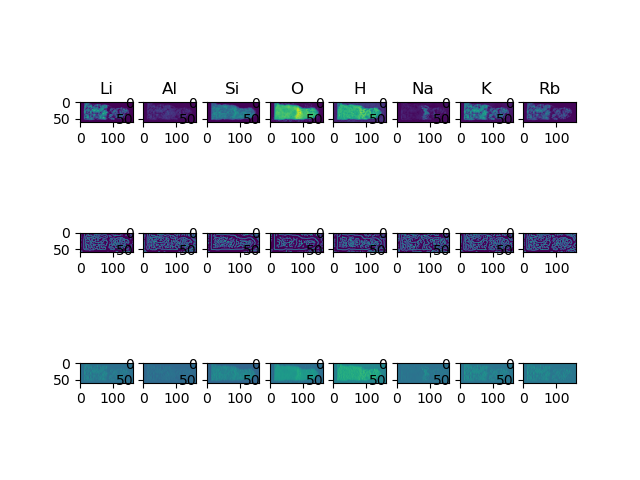

In [17]:
fig,ax=subplots(3,len(el))
for i in range(len(el)):
    c_map=maps[find_index(wavelengths,el[i]),:,:]
    ax[0,i].imshow(c_map)
    ax[0,i].set_title(el_n[i])
    ax[1,i].imshow(feature.canny(c_map*255,sigma=2))
    ax[2,i].imshow(gabor(c_map*255, frequency=0.6)[0])

In [18]:
edge_maps=[]
for w in tqdm(range(new_maps.shape[0])):
    current_map=new_maps[w,:,:]*600
    edges = feature.canny(current_map,sigma=1.5)
    edge_maps.append(edges)
edge_maps=np.array(edge_maps,dtype=int)
texture_maps=[]

for w in tqdm(range(new_maps.shape[0])):
    current_map=new_maps[w,:,:]
    filt_real, filt_imag = gabor(current_map, frequency=0.6) #lower f, more sensitivty to detail
    texture_maps.append(filt_real)
texture_maps=np.array(texture_maps)


100%|██████████| 55/55 [00:00<00:00, 648.18it/s]


In [19]:
el_n

['Li', 'Al', 'Si', 'O', 'H', 'Na', 'K', 'Rb']

In [20]:
n_clusters=10
kmeans = sklearn.cluster.KMeans(n_clusters = n_clusters,random_state=0)
 
new_features=new_maps*500+edge_maps*20+texture_maps*200
features=new_features.reshape(-1,maps.shape[2]*maps.shape[1])

#from sklearn.preprocessing import MaxAbsScaler
#transformer = MaxAbsScaler().fit(features)

#features=transformer.transform(features)
a=kmeans.fit_predict(features)
labels = kmeans.labels_
clusters_c = np.array(kmeans.cluster_centers_)

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


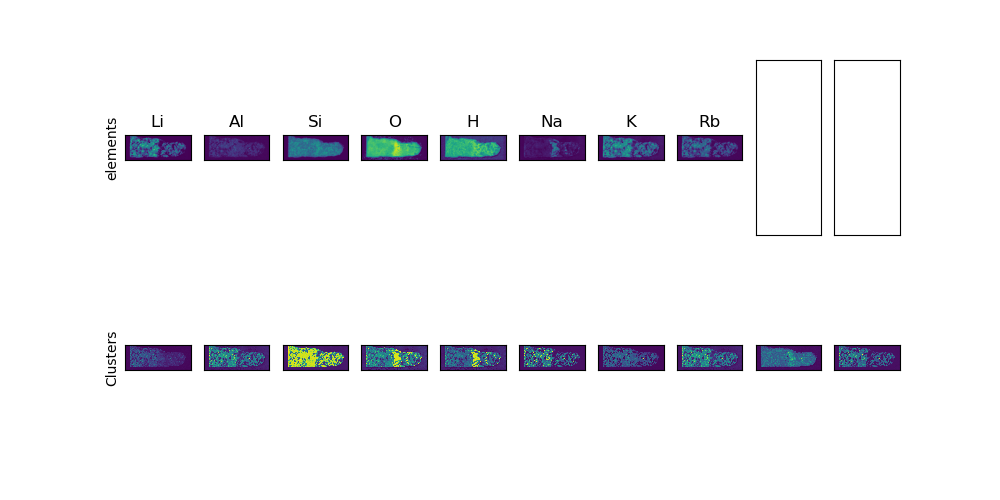

In [21]:
fig,ax=subplots(2,n_clusters,figsize=(10,5))
for i in range(n_clusters):
    if i<len(el):
        wav=find_index(wavelengths,el[i])
        ax[0,i].imshow(maps[wav,:,:])
        ax[0,i].set_title(el_n[i])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[0,0].set_ylabel('elements')
    ax[1,0].set_ylabel('Clusters')

    ax[1,i].imshow(clusters_c[i].reshape(maps.shape[1], maps.shape[2]), interpolation = 'none')

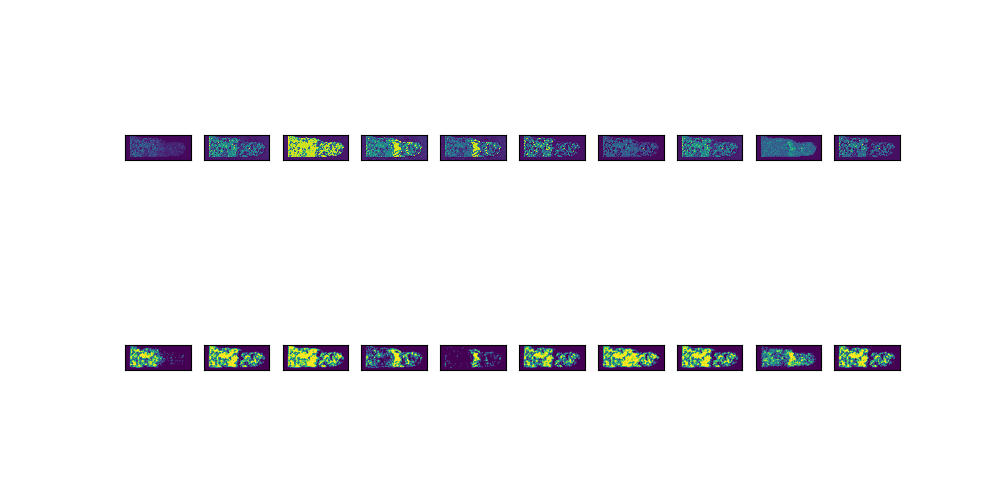

In [22]:
sample_xmin=10
sample_xmax=50
sample_ymin=20
sample_ymax=135


fig,ax=subplots(2,n_clusters,figsize=(10,5))
for i in range(n_clusters):
    if i<len(el):
        wav=find_index(wavelengths,el[i])
        ax[0,i].imshow(maps[wav,:,:])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    m=clusters_c[i].reshape(maps.shape[1], maps.shape[2])
    ax[0,i].imshow(m, interpolation = 'none')

    t=threshold_otsu(m[sample_xmin:sample_xmax,sample_ymin:sample_ymax])
    b=m>t

    cleaned_map = erosion(b, square(1))
    cleaned_map = closing(cleaned_map, square(3)) 
    
    ax[1,i].imshow(b)


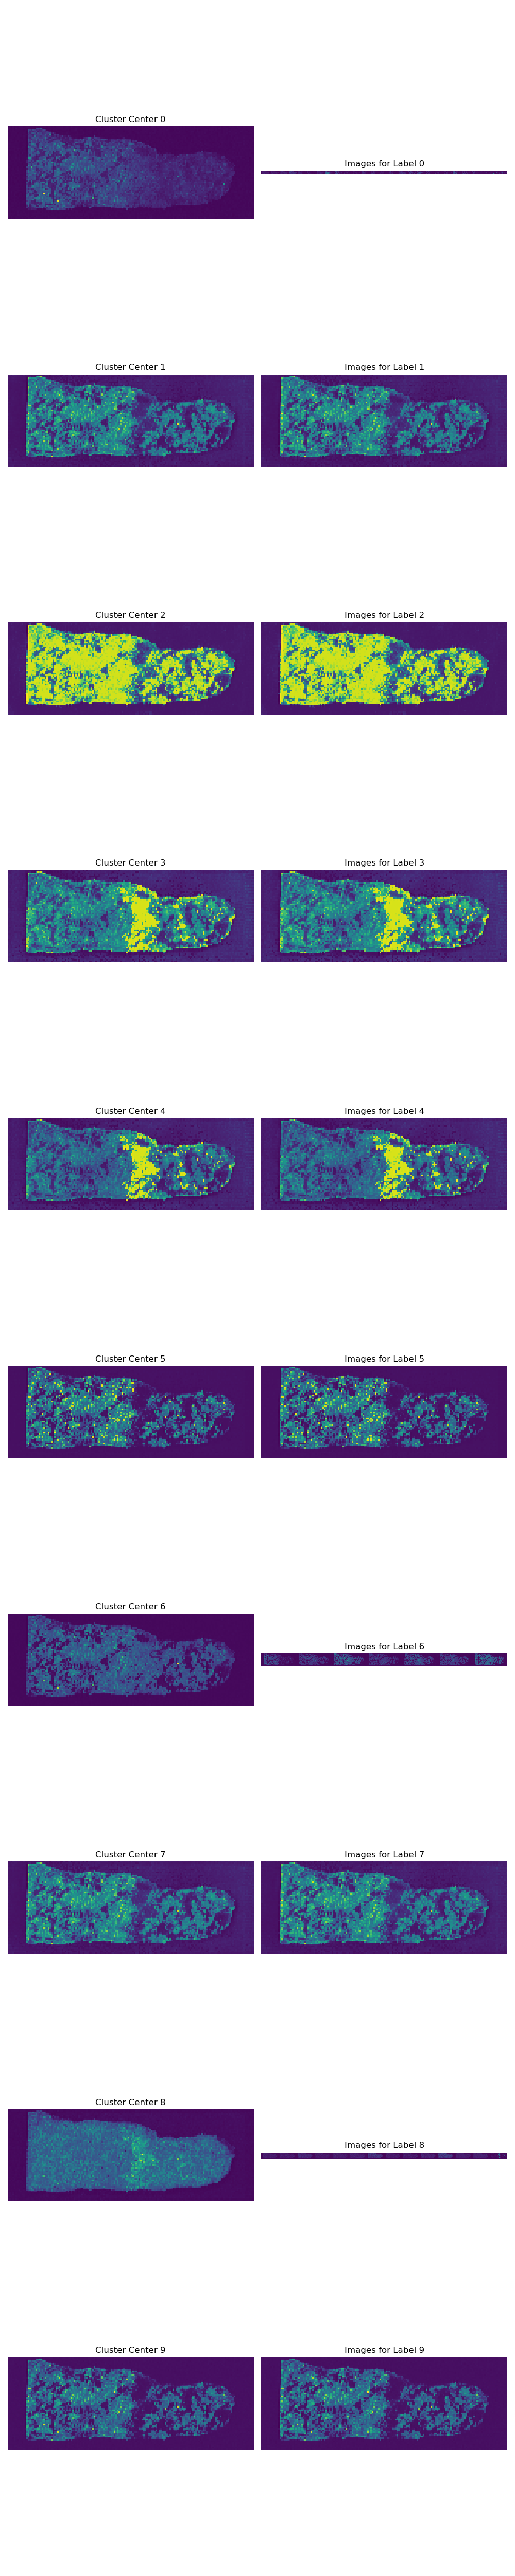

In [23]:
# verificar mapas classificados em cada cluster
import numpy as np
import matplotlib.pyplot as plt

# Assuming the following variables are defined:
# - labels: your labels array from k-means
# - clusters_c: your cluster centers array
# - features: the array of features/images used in k-means clustering
# - maps: used to determine the reshaping dimensions
%matplotlib widget
# Reshape dimensions
height, width = maps.shape[1], maps.shape[2]

# Find unique labels
unique_labels = np.unique(labels)

# Create subplots with enough space to visualize
fig, ax = plt.subplots(len(unique_labels), 2, figsize=(10, 5 * len(unique_labels)))

for i, label in enumerate(unique_labels):
    # Display the cluster center
    ax[i, 0].imshow(clusters_c[label].reshape(height, width), interpolation='none')
    ax[i, 0].set_title(f'Cluster Center {label}')
    ax[i, 0].axis('off')

    # Collect and display all images corresponding to this label
    label_indices = np.where(labels == label)[0]
    all_features = [features[idx].reshape(height, width) for idx in label_indices]
    
    # Display images
    combined_image = np.concatenate(all_features, axis=1)  # Combine images side by side
    ax[i, 1].imshow(combined_image, interpolation='none')
    ax[i, 1].set_title(f'Images for Label {label}')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [24]:
# obter comprimentos de onda dos mapas classificados em cada cluster

height, width = maps.shape[1], maps.shape[2]

unique_labels = np.unique(labels)



for i, label in enumerate(unique_labels):
    label_indices = np.where(labels == label)[0]
    all_wavs = [new_wavs[idx][0] for idx in label_indices]
    
    print('cluster', i, '\n')
    print('wavelengths:', all_wavs, '\n')


cluster 0 

wavelengths: [212.35287475585938, 221.6176300048828, 243.42352294921875, 251.38937377929688, 259.9234313964844, 261.1534118652344, 263.0770568847656, 280.23974609375, 285.18017578125, 302.03424072265625, 358.0569763183594, 371.9220886230469, 373.4132080078125, 374.8765563964844, 381.973388671875, 390.49090576171875, 394.234619140625, 395.9651184082031, 404.5768127441406, 427.14019775390625, 432.5477600097656, 438.3286437988281, 460.2378234863281, 518.21728515625, 568.1207275390625, 568.7044677734375, 851.91162109375] 

cluster 1 

wavelengths: [769.7670288085938] 

cluster 2 

wavelengths: [670.7127075195312] 

cluster 3 

wavelengths: [588.8667602539062] 

cluster 4 

wavelengths: [589.466064453125] 

cluster 5 

wavelengths: [610.224365234375] 

cluster 6 

wavelengths: [279.5352478027344, 308.1724548339844, 309.2209777832031, 394.28546142578125, 394.3193054199219, 396.029052734375, 396.0768737792969] 

cluster 7 

wavelengths: [766.3984985351562] 

cluster 8 

wavelength

In [25]:
from AnalysisTools.analysis import AnalyticsToolkit
toolkit=AnalyticsToolkit()
emission_database=toolkit.process_database(ion_num=1)

database_lines=emission_database[:,2]
database_elements=emission_database[:,0]

In [26]:
elements_of_cluster = []

def find_index(wavelengths, target_wavelength):
    return np.abs(wavelengths - target_wavelength).argmin()

def calculate_intersection(map1, map2):
    return np.sum((map1 > 0) & (map2 > 0))

for i, label in enumerate(unique_labels):

    label_indices = np.where(labels == label)[0]
    all_wavs = [new_wavs[idx][0] for idx in label_indices]
    indexes = [np.abs(database_lines - wav).argmin() for wav in all_wavs]
    elements = database_elements[indexes]
    element_counts = Counter(elements)

    unique_elements = np.unique(elements)
    intersections = {}

    # Calculate intersection for all unique elements
    for element in unique_elements:
        element_indices = np.where(database_elements == element)[0]
        total_intersection = 0
        for el_idx in element_indices:
            ref_wavelength_index = find_index(wavelengths, database_lines[el_idx])
            ref_map = spectrum[:, :, ref_wavelength_index]
            ref_threshold = threshold_otsu(ref_map[sample_xmin:sample_xmax, sample_ymin:sample_ymax])
            ref_binary_map = ref_map > ref_threshold

            for idx in label_indices:
                map_to_compare = new_maps[idx]
                map_threshold = threshold_otsu(map_to_compare[sample_xmin:sample_xmax, sample_ymin:sample_ymax])
                map_binary = map_to_compare > map_threshold
                total_intersection += calculate_intersection(ref_binary_map, map_binary)

        avg_intersection = total_intersection / len(element_indices)
        intersections[element] = avg_intersection

    # Case when there is only one unique element
    if len(unique_elements) == 1:
        most_common_element = unique_elements[0]
        # Only proceed if the avg_intersection is above the threshold
        avg_intersection = intersections[most_common_element]
        ref_wavelength_index = find_index(wavelengths, database_lines[element_indices[0]])  # Use an index from element_indices
        ref_map = spectrum[:, :, ref_wavelength_index]
        ref_threshold = threshold_otsu(ref_map[sample_xmin:sample_xmax, sample_ymin:sample_ymax])
        ref_binary_map = ref_map > ref_threshold

        if avg_intersection / np.sum(map_binary) < 0.3:
            # Skip this element if intersection is too low
            continue

        count = avg_intersection
    else:
        # Case with multiple unique elements
        most_common_element = max(intersections, key=intersections.get)
        count = intersections[most_common_element]

    print('cluster', i)
    print('elements of closest values:', elements, '\n')
    print('most common element:', most_common_element, 'with intersection count:', count, '\n')
    elements_of_cluster.append(most_common_element)



cluster 0
elements of closest values: ['Fe' 'Fe' 'Fe' 'Si' 'Fe' 'Ti' 'Si' 'Pb' 'Fe' 'Fe' 'Fe' 'Mn' 'Fe' 'Fe'
 'Fe' 'Si' 'Al' 'Ti' 'Fe' 'Fe' 'Fe' 'Fe' 'Li' 'Mg' 'Ti' 'Na' 'Rb'] 

most common element: Al with intersection count: 33129.0 

cluster 1
elements of closest values: ['K'] 

most common element: K with intersection count: 2526.0 

cluster 2
elements of closest values: ['Li'] 

most common element: Li with intersection count: 2238.7 

cluster 4
elements of closest values: ['Na'] 

most common element: Na with intersection count: 435.25 

cluster 6
elements of closest values: ['Mn' 'Al' 'Al' 'Al' 'Al' 'Al' 'Al'] 

most common element: Al with intersection count: 15398.272727272728 

cluster 7
elements of closest values: ['K'] 

most common element: K with intersection count: 2521.0 

cluster 8
elements of closest values: ['Si' 'Si' 'Si' 'Fe' 'Fe' 'Fe' 'Si' 'Si' 'Si' 'Ti' 'Si' 'Ti' 'Ti' 'Rb'] 

most common element: Si with intersection count: 25331.0 

cluster 9
elements of closest

In [27]:
elements_unique=[]
clusters_unique=[]
for i in range(len(elements_of_cluster)):
    if elements_of_cluster[i] in elements_unique:
        continue
    else:
        elements_unique.append(elements_of_cluster[i])
        clusters_unique.append(clusters_c[i])

In [28]:
clusters_unique=np.array(clusters_unique)
elements_unique=np.array(elements_unique)
clusters_reshaped=clusters_unique.reshape(-1,maps.shape[1],maps.shape[2])
cluster_label=elements_unique

In [29]:
#todos os mapas sem background
sel_maps=maps

sel_maps_f=sel_maps.reshape(-1,sel_maps.shape[1]*sel_maps.shape[2])
thresholds=np.array([threshold_otsu(sel_maps_f[i]) for i in range(sel_maps.shape[0])])
final_masks=[]
for map in tqdm(range(len(thresholds))):
    c_mask=np.zeros(sel_maps_f.shape[1])
    for i in range(sel_maps_f.shape[1]):
        if sel_maps_f[map,i]>thresholds[map]:
            c_mask[i]=1
    final_masks.append(c_mask)

final_masks=np.array(final_masks).reshape(-1,sel_maps.shape[1],sel_maps.shape[2])


100%|██████████| 16384/16384 [03:18<00:00, 82.36it/s] 


In [30]:
new_maps=[]
edge=[]
new_wavs=[]
for w in tqdm(range(sel_maps.shape[0])):
    current_map=final_masks[w,:,:]
    pixel_sum=np.sum(current_map[:,:10])+np.sum(current_map[:,150:])
    if pixel_sum <1:
        new_maps.append(sel_maps[w,:,:])
        new_wavs.append(wavelengths[w])
new_maps=np.array(new_maps)
print(sel_maps.shape)
print(new_maps.shape)

100%|██████████| 16384/16384 [00:02<00:00, 7370.82it/s] 


(16384, 60, 160)
(1035, 60, 160)


In [31]:
## thresholding de todos os mapas

thresholds=np.array([threshold_otsu(new_maps[i,sample_xmin:sample_xmax,sample_ymin:sample_ymax]) for i in range(new_maps.shape[0])])
new_maps=new_maps.reshape(-1,new_maps.shape[1]*new_maps.shape[2])
maps_thres=[]
for i in tqdm(range(new_maps.shape[0])):
    c_mask=np.zeros(new_maps.shape[1])
    for j in range(new_maps.shape[1]):
        if new_maps[i][j]>thresholds[i]:
            c_mask[j]=1
    maps_thres.append(c_mask)
maps_thres=np.array(maps_thres)  

100%|██████████| 1035/1035 [00:14<00:00, 69.35it/s]


In [32]:
maps_thres=maps_thres.reshape(-1,sel_maps.shape[1],sel_maps.shape[2])

In [33]:
clusters_reshaped.shape

(6, 60, 160)

In [34]:
thresholded_clusters=[]
for i in range(len(clusters_reshaped)):
    t=threshold_otsu(clusters_reshaped[i,sample_xmin:sample_xmax,sample_ymin:sample_ymax])
    b=clusters_reshaped[i]>t

    b = erosion(b, square(2))
    b = closing(b, square(3))
    thresholded_clusters.append(b)
thresholded_clusters=np.array(thresholded_clusters)

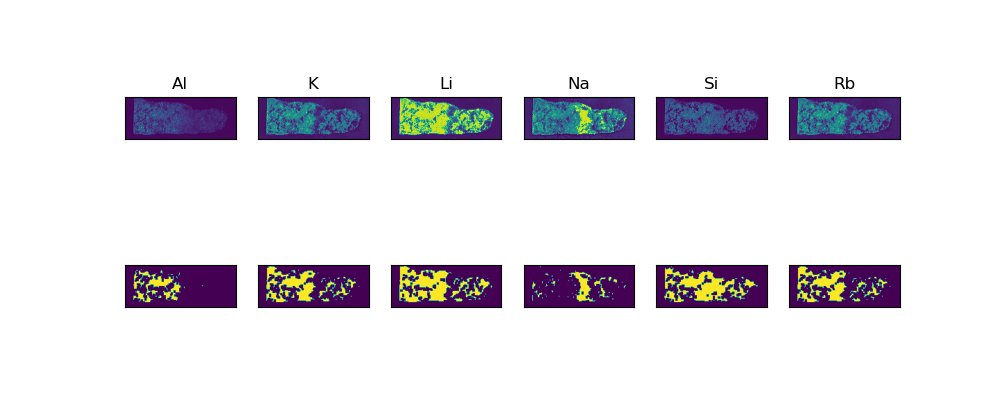

In [35]:
fig,ax=subplots(2,len(cluster_label),figsize=(10,4))
for i in range(len(cluster_label)):
    ax[0,i].imshow(clusters_reshaped[i])
    ax[1,i].imshow(thresholded_clusters[i])
    ax[0,i].set_title(cluster_label[i])

    for j in range(2):
        ax[j,i].set_xticks([])
        ax[j,i].set_yticks([])


In [36]:
for i in range(maps_thres.shape[0]):
    cleaned_map = erosion(maps_thres[i], square(2))
    cleaned_map = closing(cleaned_map, square(3))  # disk(2) or other sizes
    maps_thres[i]=cleaned_map
    

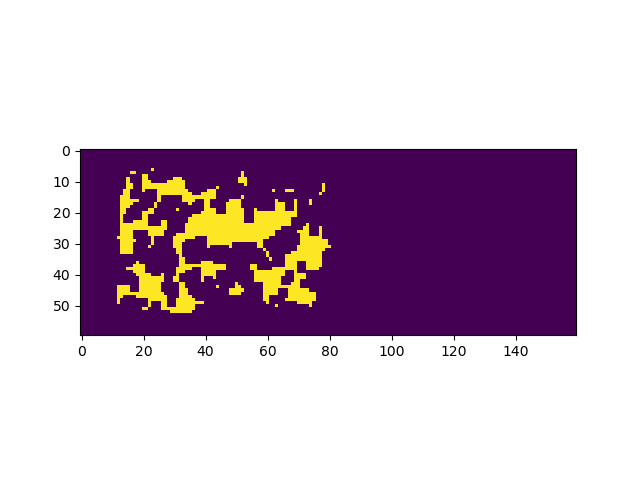

In [37]:
int_test=np.logical_and(thresholded_clusters[0],thresholded_clusters[1])
plt.figure()
plt.imshow(int_test)

In [38]:
intersections_c=[]
cluster_groups=[]
for i in range(maps_thres.shape[0]):
    intersections=[]
    clusters_n=[]
    for j in range(thresholded_clusters.shape[0]):
        cont=np.sum(np.logical_and(maps_thres[i],thresholded_clusters[j]))/np.sum(maps_thres[i])
        print(cont)
        intersections.append(cont)
        if cont>0.6:
            clusters_n.append(j)

    intersections_c.append(intersections)
    cluster_groups.append(clusters_n)
intersections_c=np.array(intersections_c)

0.033967391304347824
0.04755434782608696
0.11005434782608696
0.24048913043478262
0.2703804347826087
0.04755434782608696
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5219638242894057
0.7803617571059431
0.8275193798449613
0.3339793281653747
0.9974160206718347
0.7713178294573644
0.05238095238095238
0.06349206349206349
0.11904761904761904
0.33015873015873015
0.37936507936507935
0.05873015873015873
0.0620384047267356
0.07680945347119646
0.12850812407680945
0.3072378138847858
0.36779911373707536
0.0723781388478582
0.08534322820037106
0.14100185528756956
0.212430426716141
0.2857142857142857
0.3812615955473098
0.1326530612244898
0.10202492211838006
0.13551401869158877
0.22274143302180685
0.29361370716510904
0.3940809968847352
0.1292834890965732
0.06697674418604652
0.10046511627906977
0.1786046511627907
0.31627906976744186
0.38046511627906976
0.09209302325581395
0.1
0.1597222222222222
0.24930555555555556
0.2847222222222222
0.39861111111111114
0.15208333333333332
0.07610474631751228
0.11129

C:\Users\Joana\AppData\Local\Temp\ipykernel_12472\20601301.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cont=np.sum(np.logical_and(maps_thres[i],thresholded_clusters[j]))/np.sum(maps_thres[i])


nan
nan
nan
0.8131578947368421
0.9754385964912281
1.0
0.10087719298245613
0.9508771929824561
0.9692982456140351
1.0
1.0
1.0
0.5714285714285714
1.0
1.0
1.0
1.0
1.0
0.4
1.0
1.0
1.0
1.0
1.0
0.5
1.0
1.0
1.0
1.0
1.0
0.46153846153846156
1.0
1.0
1.0
1.0
1.0
0.5
1.0
1.0
1.0
1.0
1.0
0.5454545454545454
1.0
1.0
1.0
1.0
1.0
0.4166666666666667
1.0
1.0
1.0
1.0
1.0
0.6
1.0
1.0
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
0.8390901432181971
0.9679865206402696
1.0
0.09772535804549284
0.9654591406908172
0.962089300758214
0.8540692235734331
0.9756782039289055
0.9990645463049579
0.1038353601496726
0.9653882132834425
0.9691300280636108
0.8724279835390947
0.977366255144033
0.9979423868312757
0.11625514403292181
0.9722222222222222
0.9753086419753086
0.7996794871794872
0.9743589743589743
1.0
0.0921474358974359
0.9607371794871795
0.9639423076923077
0.8325449385052034
0.9687795648060549
0.9990539262062441
0.110690

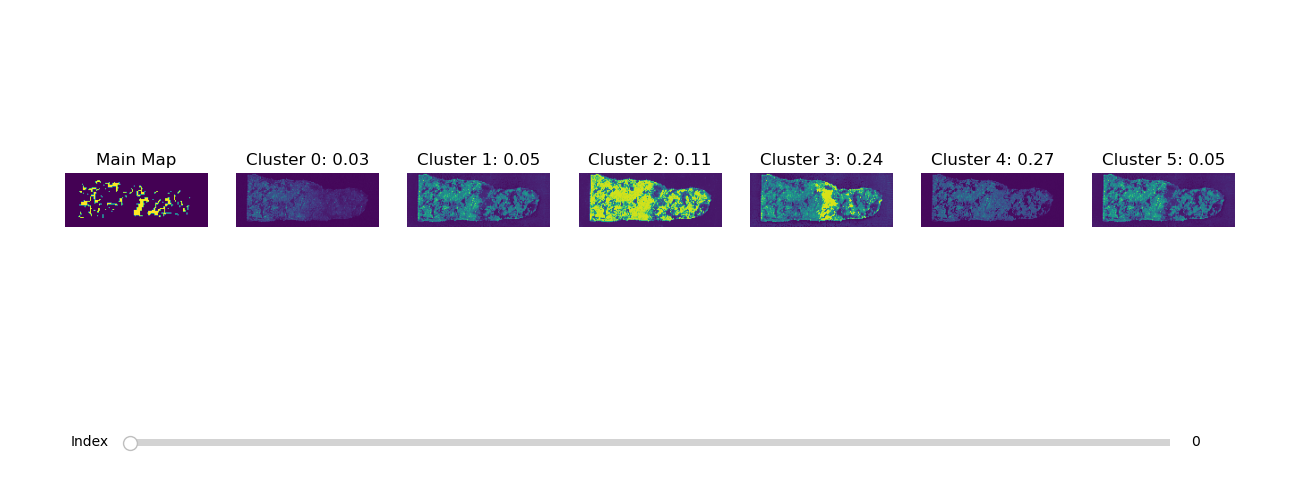

In [39]:
%matplotlib widget
# Create the figure and initial plots
fig, axes = plt.subplots(1, thresholded_clusters.shape[0] + 1, figsize=(13, 5))
plt.subplots_adjust(left=0.05, bottom=0.25, right=0.95, top=0.95)

# Plot the main new_map[i]
main_im = axes[0].imshow(maps_thres[0], cmap='viridis')
axes[0].set_title("Main Map")

# Remove x and y ticks for the main map
axes[0].axis('off')

# Plot the thresholded clusters
cluster_ims = []
for j in range(thresholded_clusters.shape[0]):
    cluster_im = axes[j + 1].imshow(clusters_reshaped[j], cmap='viridis')
    cluster_ims.append(cluster_im)
    axes[j + 1].set_title(f"Cluster {j}: {round(intersections_c[0, j],2)}")
    axes[j + 1].axis('off')  # Remove x and y ticks for each cluster plot

ax_slider = plt.axes([0.1, 0.1, 0.8, 0.03], facecolor='lightgoldenrodyellow')
slider = Slider(ax_slider, 'Index', 0, maps_thres.shape[0] - 1, valinit=0, valstep=1)

def update(val):
    i = int(slider.val)
    main_im.set_data(maps_thres[i])
    
    for j, cluster_im in enumerate(cluster_ims):
        cluster_im.set_data(clusters_reshaped[j])
        axes[j + 1].set_title(f"Cluster {j}: {round(intersections_c[i, j],2)}")
    
    fig.canvas.draw_idle()

slider.on_changed(update)

plt.show()



In [40]:
from collections import defaultdict

# Create a dictionary to store unique entries and their counts
counts_dict = defaultdict(int)

for group in cluster_groups:
    counts_dict[tuple(group)] += 1

# Convert defaultdict to a regular dictionary
counts_dict = dict(counts_dict)

print(counts_dict)

# Create a new dictionary with names instead of indexes
named_counts_dict = {}

for indexes, count in counts_dict.items():
    if indexes == ():
        continue
    # Replace each index with the corresponding name from cluster_label
    else:
        named_keys = [cluster_label[index] for index in indexes]
        named_counts_dict[tuple(named_keys)] = count
sorted_items = sorted(named_counts_dict.items(), key=lambda x: x[1], reverse=True)

print(sorted_items)

{(): 679, (1, 2, 4, 5): 60, (0, 1, 2, 4, 5): 204, (0, 1, 2, 3, 4, 5): 46, (3, 4): 46}
[(('Al', 'K', 'Li', 'Si', 'Rb'), 204), (('K', 'Li', 'Si', 'Rb'), 60), (('Al', 'K', 'Li', 'Na', 'Si', 'Rb'), 46), (('Na', 'Si'), 46)]


(4, 60, 160)


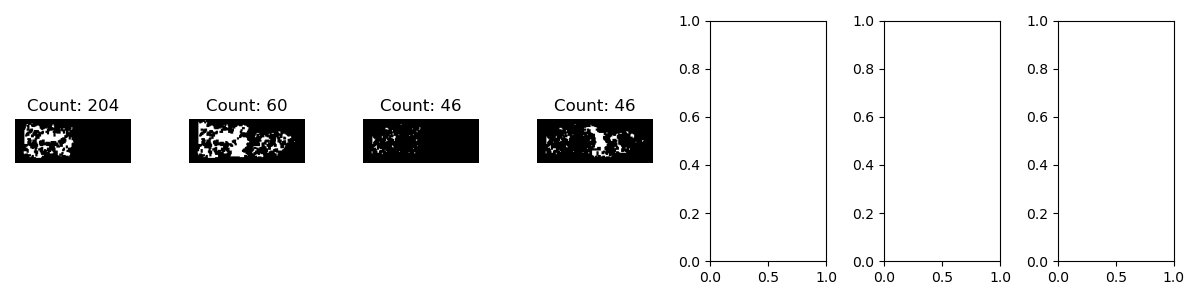

In [41]:
cluster_label_list = cluster_label.tolist()
def calculate_intersection(indices):
    # Start with the first cluster's elements
    intersection = thresholded_clusters[indices[0]]
    
    # Apply np.logical_and across the selected clusters
    for index in indices[1:]:
        intersection = np.logical_and(intersection, thresholded_clusters[index])
    
    return intersection

# Take the top 4 entries (if there are at least 4)
top_four_entries = sorted_items[:6]

# Initialize an array to store the top four intersection maps
top_four_intersections = []

# Iterate through the top four entries
for names, count in top_four_entries:
    # Convert cluster names back to indices
    indices = [cluster_label_list.index(name) for name in names]
    
    # Calculate the intersection using np.logical_and
    intersection = calculate_intersection(indices)
    
    # Append the intersection map to the list
    top_four_intersections.append(intersection)

# Convert the list of intersections into a 3D numpy array (shape: (4, height, width))
top_four_intersections_array = np.array(top_four_intersections)

# Print the shape of the resulting array (optional)
print(top_four_intersections_array.shape)

# If you want to visualize the maps
fig, axes = plt.subplots(1, 7, figsize=(12, 3))  # 1 row, 4 columns for the 4 maps
for i, intersection in enumerate(top_four_intersections):
    axes[i].imshow(intersection, cmap='gray')
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(f"Count: {top_four_entries[i][1]}")  # Set title with the count

plt.tight_layout()
plt.show()

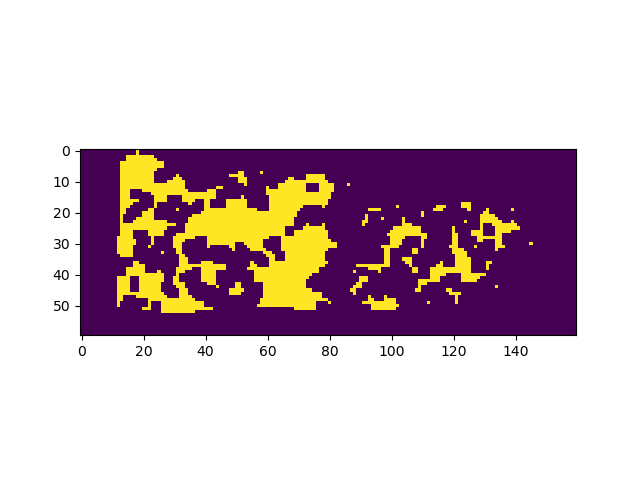

In [42]:
plt.figure()
plt.imshow(thresholded_clusters[-1])

In [43]:
top_four_entries

[(('Al', 'K', 'Li', 'Si', 'Rb'), 204),
 (('K', 'Li', 'Si', 'Rb'), 60),
 (('Al', 'K', 'Li', 'Na', 'Si', 'Rb'), 46),
 (('Na', 'Si'), 46)]

[]

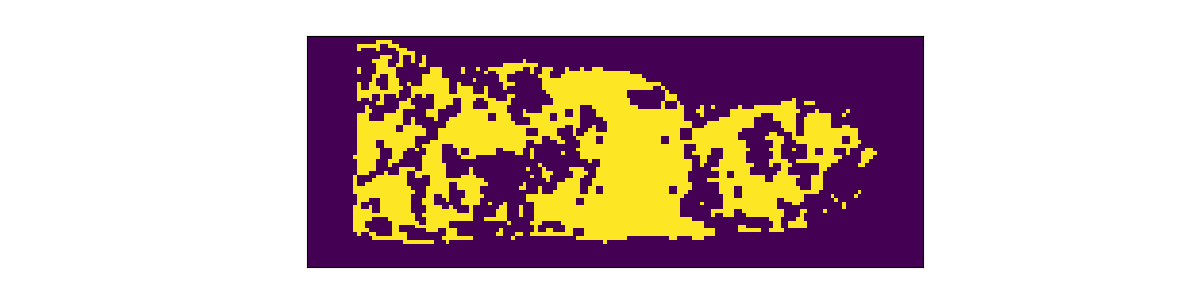

In [402]:
fig, axes = plt.subplots(1, figsize=(12, 3))  # 1 row, 4 columns for the 4 maps
combination=np.logical_or(top_four_intersections[0],top_four_intersections[1])
axes.imshow(combination)
axes.set_xticks([])
axes.set_yticks([])

[]

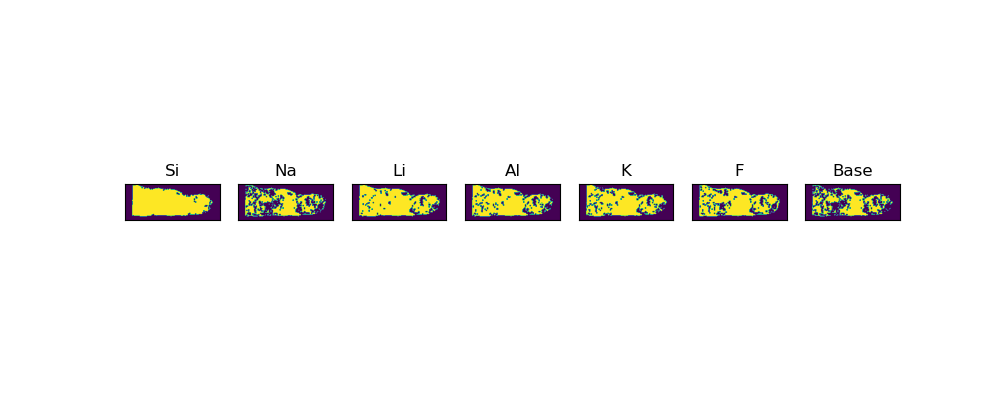

In [403]:
fig,ax=plt.subplots(1,len(elements_of_cluster_unique)+1,figsize=(10,4))
base=np.logical_or(top_four_intersections[0],top_four_intersections[1])
for i in range(len(elements_of_cluster_unique)):
    new=np.logical_or(base,thresholded_clusters[i])
    ax[i].imshow(new)
    ax[i].set_title(cluster_label[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

ax[-1].imshow(base)
ax[-1].set_title('Base')
ax[-1].set_xticks([])
ax[-1].set_yticks([])

# Amostra 3

In [226]:

filename = '3.quartz_feldspar'
def read_data_map(file):
 
    hf = h5py.File(file + '.h5', 'r')
    sample = file.split("\\")[-1]
    keys = [key for key in hf.keys()]
    sample = keys[0].split(' ')[-1]
 
    spectrums = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['Shot_0']['Pro']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    positions = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['position']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    wavelengths = np.array(hf['System properties']['wavelengths'])
 
   
    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
   
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:, 0],positions[:, 1]))
    spectrums = spectrums[indexes, :]
    spectrums = np.array(spectrums.reshape((ny, nx, -1)))
    # print(spectrums.shape)
    positions = np.array(positions[indexes])
   
    hf.close()
    return  spectrums,positions,wavelengths


spectrum, positions,wavelengths = read_data_map(filename)

pro_data = 1*spectrum

pro_data_norm=pro_data.copy()
for i in range(0,pro_data.shape[0]):
    for j in range(0,pro_data.shape[1]):
        spec = 1 * pro_data[i,j, :]
        sum_spec=np.sum(spec)
        pro_data_norm[i,j,:]=spec/sum_spec
pro_data_norm=np.array(pro_data_norm)



In [229]:
positions[:10]

array([[0., 0.],
       [1., 0.],
       [2., 0.],
       [3., 0.],
       [4., 0.],
       [5., 0.],
       [6., 0.],
       [7., 0.],
       [8., 0.],
       [9., 0.]], dtype=float32)

In [227]:
pro_data_norm.shape

(90, 80, 16384)

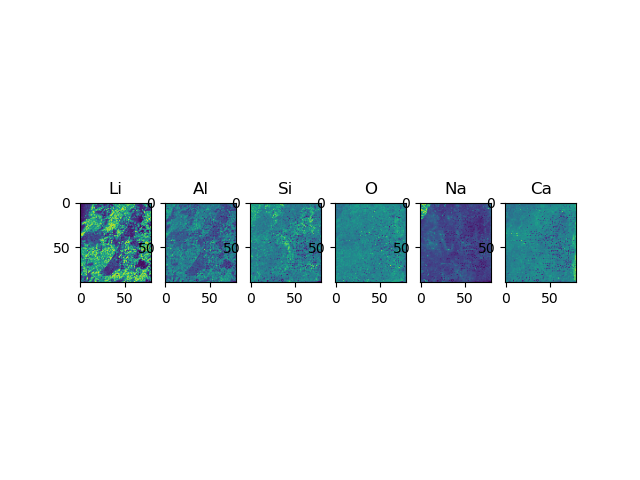

In [230]:
maps=pro_data_norm.copy()
wavelengths=wavelengths.flatten()
maps=np.transpose(maps,axes=(2,0,1))
el=[610.22,309.27,288.13,777.194,588.99,422.67]
el_n=['Li','Al','Si','O','Na','Ca']

fig,ax=subplots(1,len(el))
for i in range(len(el)):
    ax[i].imshow(maps[find_index(wavelengths,el[i])])
    ax[i].set_title(el_n[i])
normalized_spec1=np.transpose(maps.reshape(-1,maps.shape[1],maps.shape[2]),axes=(1,2,0))



100%|██████████| 16384/16384 [00:06<00:00, 2401.46it/s]


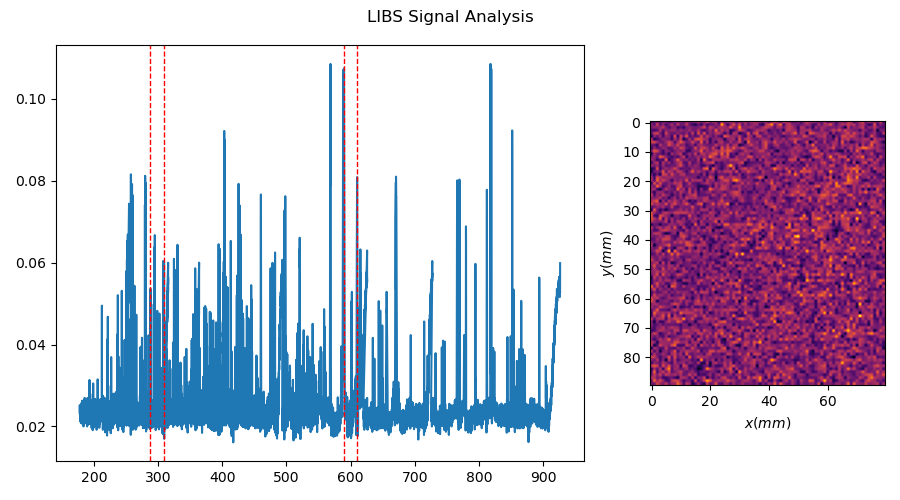

In [233]:
nx, ny = normalized_spec1.shape[1], normalized_spec1.shape[0]
dx = 0.5
dy = 0.5
 
freqs_x = 2*np.pi*np.fft.fftfreq(nx, dx)
freqs_y = 2*np.pi*np.fft.fftfreq(ny, dy)
 
def fft_feature(mmap, pixel_size_small):
    fft_map = np.array([np.fft.fftshift(np.fft.fft2(mmap[:, :, i])) for i in tqdm(range(0, (mmap.shape[-1])))])
    fft_map[:, fft_map.shape[1]//2, fft_map.shape[2]//2] = 0
 
    kxx, kyy = np.meshgrid(np.fft.fftshift(freqs_x), np.fft.fftshift(freqs_y))
 
    object_size_small = pixel_size_small*dx
    size_kspace_small = 2*np.pi/object_size_small/2*1.5
 
    R = abs(np.sqrt(kxx**2 + kyy**2))
 
    sum1 = np.sum(np.abs(fft_map[:,(R < size_kspace_small)]), axis = (1))
    max1 = np.sum(np.abs(fft_map), axis = (1, 2))
 
    sums = np.array(sum1)/np.array(max1)
 
    return sums, fft_map
 
sums, fft_m = fft_feature(normalized_spec1, 10)

find_index = lambda wavelenghts,w : np.argmin(np.abs(wavelengths-w))
    
%matplotlib widget
fig, ax = subplots(1,2, figsize = (9, 5), gridspec_kw = {'width_ratios': [0.9, 0.4]})
fig.suptitle('LIBS Signal Analysis')
el=[610.22,309.27,288.13,588.99]
el_n=['Li','Al','Si','Na']

axs = ax[0]
axs.plot(wavelengths,sums)
for i in range(len(el)):
    axs.axvline(el[i],linestyle='--',color='red',lw=1)
axs = ax[1]
axs.imshow(maps[100,:, :], cmap = cm.inferno)
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')



def update_map(wn):
    im = ax[1].imshow(maps[wn,:, :],
                     interpolation = 'none')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths, ix)
    if event.inaxes == ax[0] or ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()


In [234]:
peaks=scipy.signal.find_peaks(sums)[0]
sel_maps=[]
sel_wavs=[]
heights=sums[peaks]
for i in range(len(peaks)):
    if heights[i]>0.06:
        sel_maps.append(maps[peaks[i]])
        sel_wavs.append([wavelengths[peaks[i]]])

sel_maps=np.array(sel_maps)
sel_maps=sel_maps.reshape(-1,maps.shape[1],maps.shape[2])
sel_wavs=np.array(sel_wavs)


In [235]:
new_maps=sel_maps
new_wavs=sel_wavs

In [241]:
edge_maps=[]
for w in tqdm(range(new_maps.shape[0])):
    current_map=new_maps[w,:,:]*255
    edges = feature.canny(current_map,sigma=1.5)
    edge_maps.append(edges)
edge_maps=np.array(edge_maps,dtype=int)
texture_maps=[]

for w in tqdm(range(new_maps.shape[0])):
    current_map=new_maps[w,:,:]
    filt_real, filt_imag = gabor(current_map, frequency=0.6) #lower f, more sensitivty to detail
    texture_maps.append(filt_real)
texture_maps=np.array(texture_maps)

100%|██████████| 63/63 [00:00<00:00, 1357.90it/s]


In [242]:
n_clusters=6
kmeans = sklearn.cluster.KMeans(n_clusters = n_clusters,random_state=0)
 
new_features=new_maps*500+edge_maps*0.1+texture_maps*200
features=new_features.reshape(-1,maps.shape[2]*maps.shape[1])

#from sklearn.preprocessing import MaxAbsScaler
#transformer = MaxAbsScaler().fit(features)

#features=transformer.transform(features)
a=kmeans.fit_predict(features)
labels = kmeans.labels_
clusters_c = np.array(kmeans.cluster_centers_)

c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


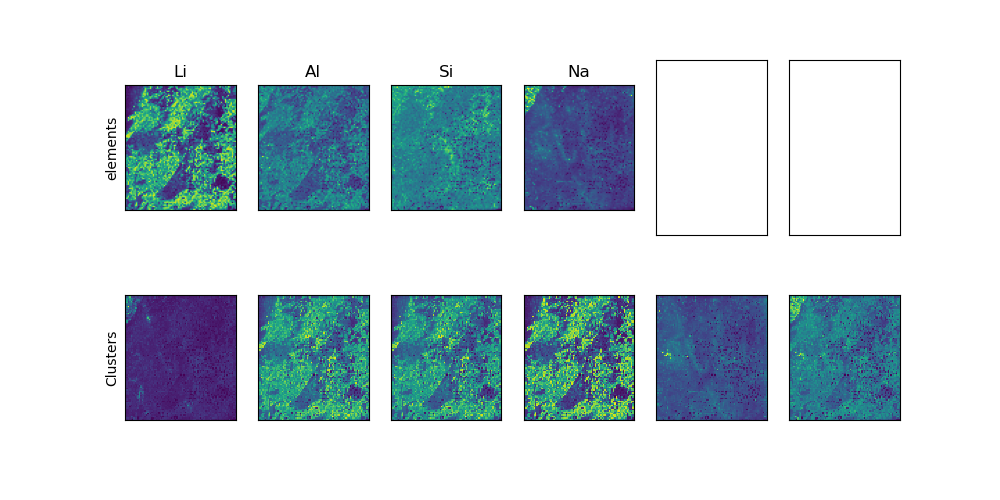

In [243]:
fig,ax=subplots(2,n_clusters,figsize=(10,5))
for i in range(n_clusters):
    if i<len(el):
        wav=find_index(wavelengths,el[i])
        ax[0,i].imshow(maps[wav,:,:])
        ax[0,i].set_title(el_n[i])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[0,0].set_ylabel('elements')
    ax[1,0].set_ylabel('Clusters')

    ax[1,i].imshow(clusters_c[i].reshape(maps.shape[1], maps.shape[2]), interpolation = 'none')